# Task 2 - Naive Bayes: Ham/Spam

In [1]:
# Librerias base
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt



## 2.1 Lectura y limpieza del dataset

In [2]:
#cargar los datos 
with open("entrenamiento.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

#separar la categoria y el mensaje  del dataset
data =[]
for line in lines: 
    category, message = line.strip().split("\t",1)
    data.append([category, message])

#crear el dataframe
df = pd.DataFrame(data, columns=["category", "message"])


In [3]:
#exploracion de los datos
print("\nexploracion de los datos: ")
print("\nmostrar las primeras filas: ")
print(df.head())

#resumen del set de datos
print("\nresumen: ")
print(df.describe())

#obtener el tipo de datos
print("\n tipo de datos: ")
print(df.dtypes)



exploracion de los datos: 

mostrar las primeras filas: 
  category                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

resumen: 
       category                 message
count      5565                    5565
unique        2                    5153
top         ham  Sorry, I'll call later
freq       4818                      30

 tipo de datos: 
category    object
message     object
dtype: object


In [4]:
#limpieza de los datos
print("\nlimpieza de los datos: ")

#reemplazar valores vacios
df = df.replace(r'^\s*$', np.nan, regex=True)

#eliminar filas con valores nulos
df = df.dropna()

#revision de valores duplicados
print("\nencontar valores duplicados: ")
print(df.duplicated().sum())

#eliminar valores duplicados

df = df.drop_duplicates()

#revision de valores nulos despues de la limpieza
print("\nrevision de valores nulos despues de la limpieza: ")
print(df.isnull().sum())

#cambiar los datos a todo minuscula
df['message'] = df['message'].str.lower()
df['category'] = df['category'].str.lower()

#eliminar caracteres especiales
df['message'] = df['message'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

#mostrar los datos limpios
print("\nmostrar los datos limpios: ")
print(df.head())



limpieza de los datos: 

encontar valores duplicados: 
412

revision de valores nulos despues de la limpieza: 
category    0
message     0
dtype: int64

mostrar los datos limpios: 
  category                                            message
0      ham  go until jurong point crazy available only in ...
1      ham                            ok lar joking wif u oni
2     spam  free entry in 2 a wkly comp to win fa cup fina...
3      ham        u dun say so early hor u c already then say
4      ham  nah i dont think he goes to usf he lives aroun...


**Escoger los datos de test y train**

In [5]:

#entrenar el modelo con los datos
X = df['message']
y = df['category']

#separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## 2.2 Construccion del modelo

Accuracy del modelo: 0.9592628516003879


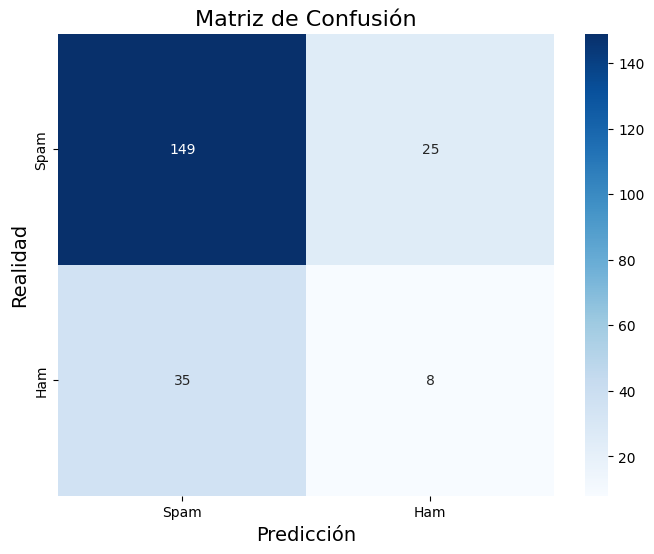

In [6]:
from collections import defaultdict

# Contar la cantidad de mensajes en cada clase (spam y ham)
total_mensajes = len(y_train)
total_spam = sum(y_train == 'spam')
total_ham = sum(y_train == 'ham')

# probabilidades 
P_spam = total_spam / total_mensajes
P_ham = total_ham / total_mensajes

vocabulario = set()
spam_palabras = defaultdict(int)
ham_palabras = defaultdict(int)

# Tokenizar y contar palabras en cada categoría
for mensaje, categoria in zip(X_train, y_train):
    palabras = mensaje.split()
    vocabulario.update(palabras)  # Añadir palabras al vocabulario general
    if categoria == 'spam':
        for palabra in palabras:
            spam_palabras[palabra] += 1
    else:
        for palabra in palabras:
            ham_palabras[palabra] += 1

# Total de palabras en cada clase
total_palabras_spam = sum(spam_palabras.values())
total_palabras_ham = sum(ham_palabras.values())
V = len(vocabulario)  # Tamaño del vocabulario

def calcular_probabilidad(mensaje, categoria):
    palabras = mensaje.split()
    
    if categoria == 'spam':
        total_clase = total_palabras_spam
        conteo_palabras = spam_palabras
        P_clase = P_spam
    else:
        total_clase = total_palabras_ham
        conteo_palabras = ham_palabras
        P_clase = P_ham

    prob = (P_clase)  
    for palabra in palabras:
        P_palabra = (conteo_palabras[palabra] + 1) / (total_clase + V)
        prob += np.log(P_palabra)  

    return prob

def predecir(mensaje):
    prob_spam = calcular_probabilidad(mensaje, 'spam')
    prob_ham = calcular_probabilidad(mensaje, 'ham')
    return 'spam' if prob_spam > prob_ham else 'ham'


y_pred = []  

for mensaje in X_test:
    prediccion = predecir(mensaje)  
    y_pred.append(prediccion)  

accuracy = sum(y_pred == y_test) / len(y_test)
conf_matrix = pd.crosstab(pd.Series(y_test, name='Real'), pd.Series(y_pred, name='Predicción'))

print("Accuracy del modelo:", accuracy)
# Crear la gráfica de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Spam", "Ham"], yticklabels=["Spam", "Ham"])

# Personalizar
plt.title("Matriz de Confusión", fontsize=16)
plt.xlabel("Predicción", fontsize=14)
plt.ylabel("Realidad", fontsize=14)
plt.show()


## 2.3 Clasificicacion de mensajes futuros

In [12]:

def predecir(mensaje):
    spamalike = calcular_probabilidad(mensaje, 'spam')
    hamalike = calcular_probabilidad(mensaje, 'ham')
    spamExp = np.exp(spamalike)
    hamExp = np.exp(hamalike)
    total = spamExp + hamExp
    return {
        'Probabilidad_de_spam': spamExp / total,
        'Probabilidad_de_ham': hamExp / total,
        'Prediccion': 'spam' if spamalike > hamalike else 'ham'
    }

# Ingreso de mensajes por consola
while True:
    mensaje = input("Ingrese un mensaje (o escriba 'salir' para terminar): ")
    if mensaje.lower() == 'salir':
        break
    resultado = predecir(mensaje)
    print(f"Mensaje: ", mensaje)
    print(f"Probabilidad Spam: {resultado['Probabilidad_de_spam']:.4f}")
    print(f"Probabilidad Ham: {resultado['Probabilidad_de_ham']:.4f}")
    print(f"Clasificación: {resultado['Prediccion']}")
    print("-" * 50)


Mensaje:  nah no creo que sea eso la vdd
Probabilidad Spam: 0.2925
Probabilidad Ham: 0.7075
Clasificación: ham
--------------------------------------------------
Mensaje:  entendiste algo? pq yo no
Probabilidad Spam: 0.4635
Probabilidad Ham: 0.5365
Clasificación: ham
--------------------------------------------------
Mensaje:  GANATE UN AUTO YA
Probabilidad Spam: 0.9715
Probabilidad Ham: 0.0285
Clasificación: spam
--------------------------------------------------
Mensaje:  PIZZAS A Q 5.50 EN EL CIT!!
Probabilidad Spam: 0.9988
Probabilidad Ham: 0.0012
Clasificación: spam
--------------------------------------------------


## 2.4 Comparación con Librerías

In [8]:
# Librerias extra

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


In [9]:
# Convierte los datos a números dando peso a las palabras
vectorizer = CountVectorizer()

model = make_pipeline(vectorizer, MultinomialNB())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9776915615906887


### ¿Cuál implementación lo hizo mejor?
Nuestra implementación tuvo un accuracy de 0.95926, mientras que la que se hizo utilizando librerías tuvo un accuracy de 0.94859. Con esto podemos ver que la que tuvo un mejor desempeño fue la creada por nosotros.

### ¿A qué se debe esta diferencia?